# Setting up Notebook

In [ ]:
# Importing numeric/statistical packages
import numpy as np
from numpy import polyfit
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Importing visualation packages
from pprint import pprint
import matplotlib.pyplot as plt

# Importing Sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Imprting predictive models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Setting random seed for consistency between runs
np.random.seed(0)

In [ ]:
# Importing Datasets
num_df = pd.read_csv("num_data.csv", delimiter = ",")
nlp_df = pd.read_csv("nlp_data.csv", delimiter = ",")

In [ ]:
# Viewing numerical dataframe
num_df.head()

,users,year,month,day,video_id,video_views,video_likes,video_dislikes,comments_count,total_comment_likes_count
0,40,2017,11,7,3r3lWi_T45g,11564.0,345.0,2.0,67.0,52.0
1,90,2017,11,8,3r3lWi_T45g,11564.0,345.0,2.0,67.0,52.0
2,79,2017,11,9,3r3lWi_T45g,11564.0,345.0,2.0,67.0,52.0
3,16,2017,11,10,3r3lWi_T45g,11564.0,345.0,2.0,67.0,52.0
4,10,2017,11,11,3r3lWi_T45g,11564.0,345.0,2.0,67.0,52.0


In [ ]:
# Viewing text (nlp) dataframe
nlp_df.head()

,video_id,accounts,adidas,ages,air,alexander,alligator,alpha,alternatives,alyx,ami,amiri,angels,anniversary,apply,aquascutum,armani,array,arrivals,aspiring,attend,authentic,authorised,avoid,badenne,badger,bag,bagging,balance,balenciaga,baracuta,base,beams,beanie,beginners,belstaff,belt,beluga,bf,bicester,...,valentino,vapor,vapormax,varsity,vest,vid,vidbio,video,vids,viewers,village,vintage,visit,visited,visiting,vists,vuitton,wanting,wars,watanabe,water,weather,weekly,wembley,westfields,westfieldsin,white,wind,wings,winner,winter,wnjoy,wol,worldwide,worth,wotherspoon,wyndham,yeezy,zee,sentiment_score
0,3Cg8-eoNXdY,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.358728
1,zgXoCGUcR9w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.211008
2,AFpME2E2GAY,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.325584
3,4TJCzY3Ph88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.213441
4,TX3TFXp2y2M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.167957


# Data Preparation and Feature Engineering

Sentiment Scores and Keywords Features made in NLP modelling notebook

In [ ]:
# Merging Dataframes
merged_df = num_df.merge(nlp_df, on='video_id')

# Removing video_id column
merged_df.drop(['video_id'], axis=1, inplace = True)

# Viewing Merged DataFrame
merged_df.head()

,users,year,month,day,video_views,video_likes,video_dislikes,comments_count,total_comment_likes_count,accounts,adidas,ages,air,alexander,alligator,alpha,alternatives,alyx,ami,amiri,angels,anniversary,apply,aquascutum,armani,array,arrivals,aspiring,attend,authentic,authorised,avoid,badenne,badger,bag,bagging,balance,balenciaga,baracuta,base,...,valentino,vapor,vapormax,varsity,vest,vid,vidbio,video,vids,viewers,village,vintage,visit,visited,visiting,vists,vuitton,wanting,wars,watanabe,water,weather,weekly,wembley,westfields,westfieldsin,white,wind,wings,winner,winter,wnjoy,wol,worldwide,worth,wotherspoon,wyndham,yeezy,zee,sentiment_score
0,40,2017,11,7,11564.0,345.0,2.0,67.0,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.176293
1,90,2017,11,8,11564.0,345.0,2.0,67.0,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.176293
2,79,2017,11,9,11564.0,345.0,2.0,67.0,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.176293
3,16,2017,11,10,11564.0,345.0,2.0,67.0,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.176293
4,10,2017,11,11,11564.0,345.0,2.0,67.0,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.176293


In [ ]:
# Checking for Nas
merged_df.isnull().values.any()

False

In [ ]:
# Removing dates before April 1st 2018, as they are not representative of whole dataset
# Due to ramp up of website
merged_df = merged_df.sort_values(by = ['year', 'month', 'day'])
merged_df = merged_df[146:]
merged_df

,users,year,month,day,video_views,video_likes,video_dislikes,comments_count,total_comment_likes_count,accounts,adidas,ages,air,alexander,alligator,alpha,alternatives,alyx,ami,amiri,angels,anniversary,apply,aquascutum,armani,array,arrivals,aspiring,attend,authentic,authorised,avoid,badenne,badger,bag,bagging,balance,balenciaga,baracuta,base,...,valentino,vapor,vapormax,varsity,vest,vid,vidbio,video,vids,viewers,village,vintage,visit,visited,visiting,vists,vuitton,wanting,wars,watanabe,water,weather,weekly,wembley,westfields,westfieldsin,white,wind,wings,winner,winter,wnjoy,wol,worldwide,worth,wotherspoon,wyndham,yeezy,zee,sentiment_score
146,206,2018,4,1,7698.0,173.0,2.0,31.0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.096326
147,279,2018,4,2,6937.0,191.0,5.0,43.0,26.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.162070
148,155,2018,4,3,6937.0,191.0,5.0,43.0,26.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.162070
149,147,2018,4,4,5165.0,209.0,5.0,52.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.177681
150,116,2018,4,5,5165.0,209.0,5.0,52.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.177681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,345,2021,6,26,3275.0,106.0,8.0,36.0,31.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.358728
1330,342,2021,6,27,3275.0,106.0,8.0,36.0,31.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.358728
1331,416,2021,6,28,3275.0,106.0,8.0,36.0,31.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.358728
1332,292,2021,6,29,3275.0,106.0,8.0,36.0,31.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.358728


In [ ]:
# Creating date column
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month', 'day']])

# Creating series with monthly user average
users_df = merged_df[['date', 'users']]
users_df.set_index('date', inplace = True)
users_series = users_df.users

Coefficients: [ 3.33892700e-09 -3.18708597e-06  1.03700116e-03 -1.34736079e-01
  6.83482828e+00  1.59558775e+02]


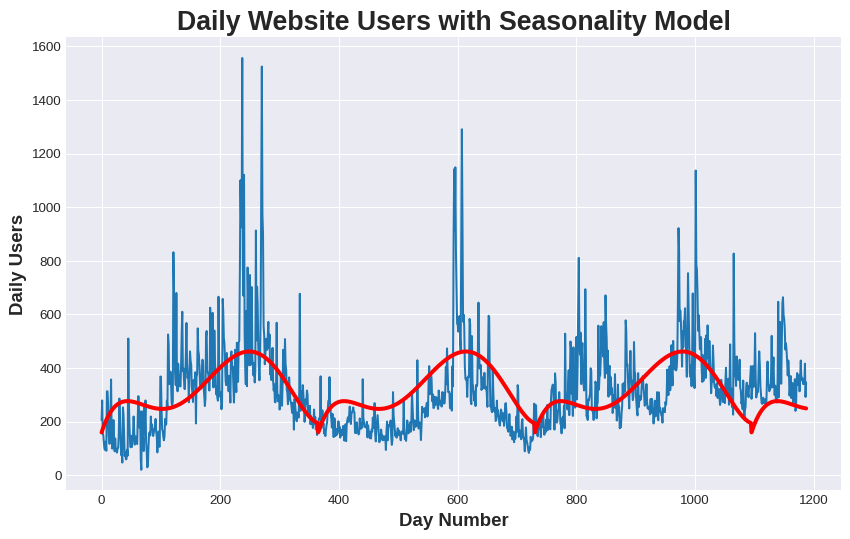

In [ ]:
#Setting style for plot
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 600/my_dpi), dpi=my_dpi)

# Calculating the yearly day for each date in user series
X = [i%365 for i in range(0, len(users_series))]

# Retrieving daily user values
y = users_series.values

# Fitting a 5th Degree Polynomial Curve to the user data
degree = 5
coef = polyfit(X, y, degree)

# Generating coefficients of the model
print('Coefficients: %s' % coef)

# plotting curve for user variable
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plotting model (red) curve over user variable
# Red Curve represents the seasonality component in the users variable
plt.plot(users_series.values)
plt.plot(curve, color='red', linewidth=3)

# Labelling Title, y and x axes
plt.title("Daily Website Users with Seasonality Model", fontsize=20, weight='bold')
plt.xlabel("Day Number", fontsize=14, weight='bold')
plt.ylabel("Daily Users", fontsize=14 , weight='bold')

#Saving figure
plt.savefig('daily_users_with_seasonality.png')

plt.show()

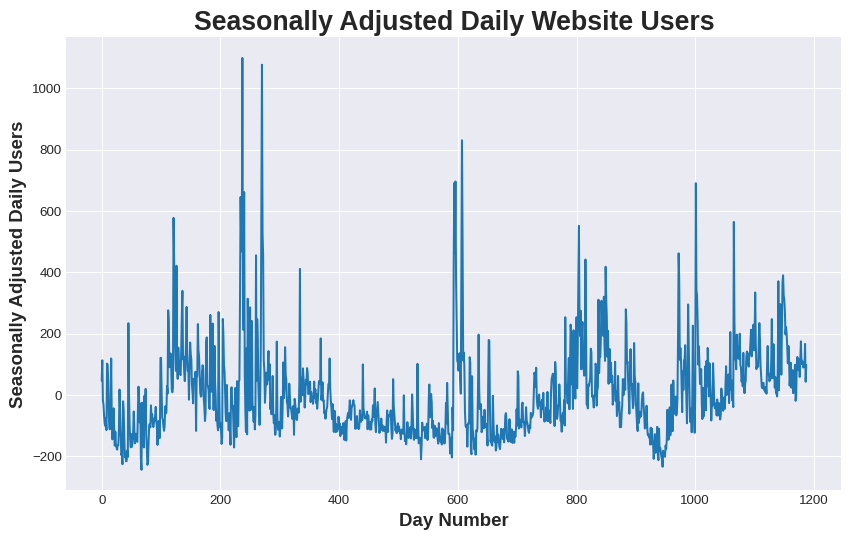

In [ ]:
#Setting style for plot
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 600/my_dpi), dpi=my_dpi)

# Retrieving daily user values
values = users_series.values

# Empty dataframe for difference between predicted seasonality model and daily user values
diff = []

# Appending difference values to an empty list
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)

# Plotting seasonally adjusted curve (removing model values from before)
# Plotting list of the differences
plt.plot(diff)

# Labelling Title, y and x axes
plt.title("Seasonally Adjusted Daily Website Users", fontsize=20, weight='bold')
plt.xlabel("Day Number", fontsize=14, weight='bold')
plt.ylabel("Seasonally Adjusted Daily Users", fontsize=14 , weight='bold')

# Saving figure
plt.savefig('seasonally_adj_daily_users.png')

plt.show()

In [ ]:
# Final Dataframe to be used for modelling
final_df = merged_df.drop(["year", "month", "day", "date"], axis = 1)
final_df.head()

,users,video_views,video_likes,video_dislikes,comments_count,total_comment_likes_count,accounts,adidas,ages,air,alexander,alligator,alpha,alternatives,alyx,ami,amiri,angels,anniversary,apply,aquascutum,armani,array,arrivals,aspiring,attend,authentic,authorised,avoid,badenne,badger,bag,bagging,balance,balenciaga,baracuta,base,beams,beanie,beginners,...,valentino,vapor,vapormax,varsity,vest,vid,vidbio,video,vids,viewers,village,vintage,visit,visited,visiting,vists,vuitton,wanting,wars,watanabe,water,weather,weekly,wembley,westfields,westfieldsin,white,wind,wings,winner,winter,wnjoy,wol,worldwide,worth,wotherspoon,wyndham,yeezy,zee,sentiment_score
146,206,7698.0,173.0,2.0,31.0,22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.096326
147,279,6937.0,191.0,5.0,43.0,26.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.162070
148,155,6937.0,191.0,5.0,43.0,26.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.162070
149,147,5165.0,209.0,5.0,52.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.177681
150,116,5165.0,209.0,5.0,52.0,18.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.177681


## Splitting Dataset

In [ ]:
# Assigning variables to predictors and label
X = final_df.drop(['users'], axis=1)
y = final_df["users"]

In [ ]:
# Splitting the dataframes into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0) # 0.25 x 0.8 = 0.2

In [ ]:
# Assessing shape of train predictors
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(712, 582)
(238, 582)
(238, 582)


In [214]:
# Splitting keywords dummy variables from other variable columns
X_train_kw = X_train.iloc[:, 5:581]
X_train_wo_kw = X_train.iloc[:, [0, 1, 2, 4, 581]]

In [ ]:
# Splitting keywords dummy variables from other variable columns
X_test_kw = X_test.iloc[:, 5:581]
X_test_wo_kw = X_test.iloc[:, [0, 1, 2, 4, 581]]

In [ ]:
# Splitting keywords dummy variables from other variable columns
X_val_kw = X_val.iloc[:, 5:581]
X_val_wo_kw = X_val.iloc[:, [0, 1, 2, 4, 581]]

## (Train set) Standard Scaler

In [ ]:
# Standard scaler
scaler = StandardScaler()

# Applying standard scaler to both dataframes
X_train_kw = scaler.fit_transform(X_train_kw)
X_train_wo_kw = scaler.fit_transform(X_train_wo_kw)

## (Train set) PCA

In [ ]:
# Indicating the initial desired level of variance to be kept
pca = PCA(0.75)

# Fitting PCA to Keywords dataframe
pca.fit(X_train_kw)

PCA(copy=True, iterated_power='auto', n_components=0.75, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Number of Principal Compontents
pca.n_components_

85

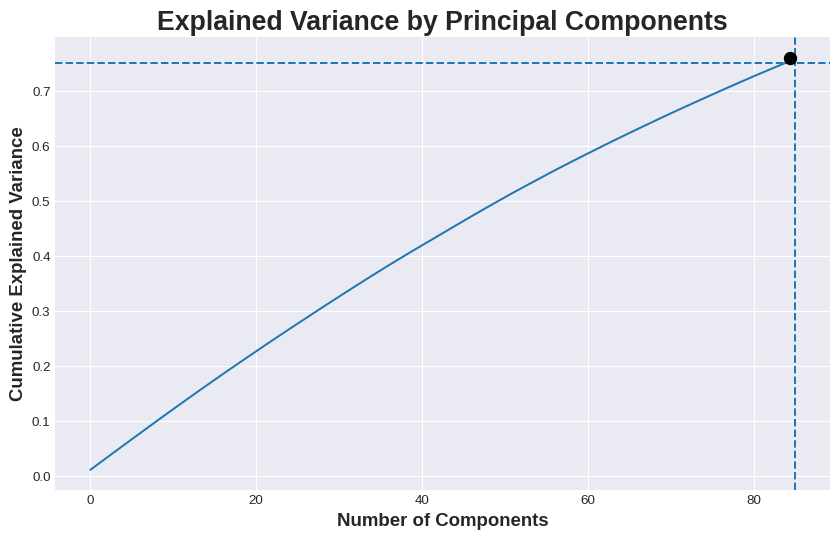

In [ ]:
#Setting style for plot
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 600/my_dpi), dpi=my_dpi)

# PCA Visualisation Assessing the Variance Explained by Components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by Principal Components', fontsize=20, weight='bold')
plt.xlabel('Number of Components', fontsize=14, weight='bold')
plt.ylabel('Cumulative Explained Variance', fontsize=14, weight='bold')

plt.axhline(y=0.75, xmin=0, xmax=63,  linestyle='--')
plt.axvline(x=85, ymin=0, ymax=1, linestyle='--')

plt.plot(84.4, 0.76, marker='o', markersize=9, color="black")

#Saving figure
#plt.savefig('pca_graph.png')

plt.show()

In [ ]:
# Explained Variance for each of the 10 Components
pca.explained_variance_ratio_

array([0.01155386, 0.01127703, 0.01115844, 0.0110811 , 0.01106862,
       0.01105942, 0.0110525 , 0.01099367, 0.01095785, 0.01092913,
       0.01082751, 0.01077333, 0.01074753, 0.01072029, 0.01057318,
       0.01053784, 0.01049764, 0.0103761 , 0.01034101, 0.01027266,
       0.01023593, 0.01019243, 0.01010084, 0.01007271, 0.00998481,
       0.00993843, 0.00992068, 0.00984672, 0.00982911, 0.00975385,
       0.00968112, 0.00966504, 0.00965042, 0.0095654 , 0.00948402,
       0.00935804, 0.00926413, 0.00916684, 0.00909328, 0.00900741,
       0.00886856, 0.00886722, 0.00886401, 0.00884855, 0.00884546,
       0.00884142, 0.00882857, 0.00865274, 0.00859905, 0.00854375,
       0.00844006, 0.00841264, 0.00817099, 0.00810515, 0.00809788,
       0.00808439, 0.00793521, 0.00783167, 0.00771894, 0.00764285,
       0.00761042, 0.00753716, 0.00753023, 0.00739591, 0.00737041,
       0.00731066, 0.0072096 , 0.00718008, 0.00717487, 0.00710081,
       0.00703691, 0.00692936, 0.00685198, 0.00684868, 0.00678

In [ ]:
# Transforming the X_train keywords through PCA
X_train_pca = pca.transform(X_train_kw)

In [ ]:
# Explaining the effect of PCA on the training regions data
old_dimensions = str(X_train_kw.shape[1])
new_dimensions = str(X_train_pca.shape[1])
variance_explained = str(round(sum(pca.explained_variance_ratio_), 3)*100)

print("PCA reduced the regions dataframe dimensions from " + old_dimensions + " to " + new_dimensions + ". These new PCA compenents explain " + variance_explained + "% of the variance within the prior variables.")

PCA reduced the regions dataframe dimensions from 576 to 85. These new PCA compenents explain 75.2% of the variance within the prior variables.


In [ ]:
# Merging PCA components to the remaining x train data
X_train_2 = pd.DataFrame(np.column_stack([X_train_wo_kw, X_train_pca]))
X_train_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,-0.513548,-0.586155,-0.671725,-0.668955,0.428609,-0.393274,-0.147047,-0.058564,-0.082144,-5.094536e-14,-0.156108,0.108807,0.059519,-0.537176,0.652048,-0.461786,0.584895,1.637968,-0.046678,-3.214533,-0.352282,3.191780,1.740330,-0.713783,0.407998,-2.798000,0.128748,-0.155291,-0.787535,-0.130773,4.237364,1.453504,1.713984,0.951633,-0.483016,0.326669,0.807020,-0.568392,3.212868,1.150273,...,0.101458,-1.181315,-0.354217,0.892148,0.122624,-2.368383,-1.029071,-0.369418,0.612872,-0.045454,-0.156921,1.424288,1.170012,-5.111820,-1.206368,-0.682056,0.460082,-0.921300,0.848588,0.832700,0.937092,-0.263502,1.177867,0.147572,-0.371991,-0.259569,-0.289235,-0.161018,0.562879,0.195496,-0.071835,1.203452,-0.725562,0.053690,1.765993,0.092501,0.262745,0.033240,-0.063728,-0.279587
1,-0.331833,-0.250317,-0.532552,-0.238618,0.025042,-1.060611,-0.914861,-0.750837,-0.987217,-4.133499e-13,-0.607750,0.183224,-0.667643,0.083252,-2.010462,-0.433724,0.488725,-1.130524,-0.009049,1.333116,-0.774498,-0.621274,-0.585747,-0.364686,-1.384807,0.619164,-0.108273,-0.561470,-0.635857,-0.328584,-0.336371,0.096146,1.467717,-0.391208,-0.487421,0.563460,0.051334,-0.139489,-0.227131,-0.290988,...,0.391335,8.061557,-6.063521,7.910543,-2.014555,2.085647,2.910797,-0.756666,-0.332446,0.517158,-0.492788,0.162715,0.422467,-0.220715,-0.075344,0.617909,-0.335764,-0.162573,0.044203,-0.117033,-0.304680,0.218590,0.132302,-0.178609,0.518455,0.123817,0.290882,-0.103045,0.337966,-0.002202,-0.049187,-0.069423,0.012143,-0.068266,-0.021780,0.639253,0.054367,0.205375,-0.182138,-0.095871
2,-0.483936,-0.490433,-0.462966,-0.508723,-0.257602,-0.500870,-0.146996,0.079590,0.423365,2.159731e-13,0.173781,0.068575,8.478383,-0.117027,-2.823559,-0.299795,0.334811,-0.142140,-0.000938,0.269831,-0.254141,0.300765,2.957864,-0.295324,0.041341,7.924916,0.704299,-0.123156,2.154889,-0.264958,2.173552,0.463048,0.959020,0.227034,-0.139700,0.011566,-0.031447,-0.051966,0.011139,0.036518,...,0.001445,0.033474,0.237794,-0.450399,0.124571,-0.171314,-0.307725,0.114572,0.033215,-0.119594,0.140992,-0.083683,-0.141289,0.125451,0.088538,-0.261168,0.170900,0.049068,-0.010386,0.046265,0.161062,-0.143528,-0.103461,0.129377,-0.361866,-0.096602,-0.272483,0.057117,-0.157052,-0.027343,0.016828,0.124019,0.022381,0.038929,-0.077208,-0.352117,-0.057358,0.033710,0.208454,0.044750
3,-0.498282,-0.500168,-0.567346,-0.334757,-0.752787,-0.345695,-0.074666,0.038643,0.123662,4.454076e-14,0.022378,0.032499,0.110865,-0.628548,1.763296,1.935525,-1.077285,-0.341663,-0.157447,-0.449867,-1.887644,-2.452052,0.151899,-0.903034,3.899549,0.127190,-3.047842,-0.054798,0.065369,-1.387476,-0.810522,2.546903,0.078229,0.302104,-0.505063,-0.134541,-0.172326,0.002505,0.905875,0.818313,...,0.020078,-0.364056,-0.319355,-0.688456,-5.336025,0.112459,-0.589906,0.729255,0.320025,0.286138,0.624527,0.300666,-0.100866,0.329912,-0.494685,0.648291,-0.352782,-1.231661,-0.903049,-2.158470,2.319127,0.725096,-0.248910,1.011515,-1.761207,2.170999,0.078073,0.321028,-0.826373,0.640994,-1.693704,0.525440,4.004765,-0.501735,-0.665658,0.631326,-0.849445,0.363416,3.295324,-0.993162
4,-0.489331,-0.519637,-0.567346,-0.646065,-0.358487,0.038692,0.731314,1.463387,6.346454,4.113439e-12,10.196673,-6.389223,-2.159901,0.350472,-2.884163,-0.482041,0.529514,-0.300531,0.006717,-0.182836,-0.220720,-0.146485,-0.036908,0.050501,-0.277812,0.007887,-0.325692,-1.067067,0.137115,-0.049801,-0.056602,0.086567,0.036977,-0.025449,0.018032,0.013660,-0.091343,0.018112,0.087809,-0.058140,...,-0.034491,0.180016,-4.753722,-2.889886,0.726848,-0.175544,-0.577523,-0.004217,0.070964,-0.036134,0.139935,-0.087916,0.063917,-0.000604,-0.061562,-0.024450,0.011667,0.123080,0.015461,-0.008983,0.009070,-0.011246,0.002073,0.024293,-0.060685,0.007384,0.012546,0.153736,0.005010,-0.0178

## (Train set) Multicollinearity Check (VIF Test)

In [ ]:
# Conducting First VIF Test
vif_results1 = [variance_inflation_factor(X_train_2.values, i) for i in range(len(X_train_2.columns))] 
vif_results1

[11.50463387206398,
 5.2838573358068235,
 14.965525592759851,
 8.62396458164871,
 6.016431355626873,
 1.686804545142435,
 1.0324248023554337,
 1.0598719964581926,
 1.031815690168932,
 1.008886458652708,
 1.0121297079861722,
 1.0344224064320762,
 1.1889198468958768,
 1.028384982398205,
 1.438648861087191,
 1.668737405710267,
 2.0587808854973355,
 1.1778760183937822,
 1.0094961820448887,
 1.0742832522733816,
 1.113946300863086,
 1.134269717226042,
 1.0864359297419814,
 1.0903303066952639,
 1.0552899568001624,
 1.1022355512526458,
 1.0113241313783525,
 1.1298722435508621,
 1.1082804675807443,
 1.0918164806461417,
 1.0240535119359617,
 1.0408208402583496,
 1.0036857642150896,
 1.0383439806062955,
 1.0142240519898769,
 1.1872943456656315,
 1.0379582782094559,
 1.181325808867265,
 1.1098470540502994,
 1.0105736693667409,
 1.0168428547691217,
 1.3348404983067554,
 1.0636935872311497,
 1.035963465297022,
 1.0087245222651091,
 1.1338570309006248,
 1.0058358553885078,
 1.025175192541174,
 1.0490

In [ ]:
# Removing video dislikes (3rd Variable) as it received a high score
X_train_3 = X_train_2.drop(2, axis = 1)

# Conducting 2nd VIF Test
vif_results1 = [variance_inflation_factor(X_train_3.values, i) for i in range(len(X_train_3.columns))] 
vif_results1

[5.011345428556553,
 4.85617450625242,
 7.870351171480688,
 6.016409286765476,
 1.4631717867722955,
 1.0318841933280511,
 1.0522352053975386,
 1.0307901635338272,
 1.007879040793038,
 1.011445692733475,
 1.03061537705467,
 1.1888829032610853,
 1.0057151489168583,
 1.438429484161786,
 1.6435968049651446,
 1.914547942512377,
 1.1776169073038183,
 1.008613908908675,
 1.0742827793608452,
 1.1121162174174928,
 1.0706205754888596,
 1.0838592910511964,
 1.0852692517563371,
 1.0520061297963046,
 1.1015373467833407,
 1.0102317257387172,
 1.1298715309006837,
 1.1000056050138358,
 1.0911831320448582,
 1.0239460110285719,
 1.0407635126288135,
 1.0036773521974014,
 1.0099997873559285,
 1.0125534125180882,
 1.1659154541729126,
 1.035231470631599,
 1.1813177436270834,
 1.1087480578283224,
 1.010273983576635,
 1.0168348558026974,
 1.3301729066619625,
 1.0631097949086274,
 1.0346632231748296,
 1.0084977780468944,
 1.0931428577565911,
 1.0058296020184392,
 1.024191398399443,
 1.0490797352253325,
 1.0184

In [ ]:
# Setting results of VIF as final
X_train_final = X_train_3
X_train_final.shape

(712, 89)

## (Test & Validation set) Standard Scaler

In [ ]:
# Standard scaler
scaler = StandardScaler()

# Applying standard scaler to both dataframes (test)
X_test_kw = scaler.fit_transform(X_test_kw)
X_test_wo_kw = scaler.fit_transform(X_test_wo_kw)

# Applying standard scaler to both dataframes (val)
X_val_kw = scaler.fit_transform(X_val_kw)
X_val_wo_kw = scaler.fit_transform(X_val_wo_kw)

## (Test & Validation set) PCA

In [ ]:
# Transforming the X_test keywords through PCA
X_test_pca = pca.transform(X_test_kw)

# Transforming the X_val keywords through PCA
X_val_pca = pca.transform(X_val_kw)

In [ ]:
# Merging PCA components to the remaining x train data
X_test_2 = pd.DataFrame(np.column_stack([X_test_wo_kw, X_test_pca]))

In [ ]:
# Merging PCA components to the remaining x train data
X_val_2 = pd.DataFrame(np.column_stack([X_val_wo_kw, X_val_pca]))

## (Test & Validation set) Drop VIF Test Variable

In [ ]:
# Removing video dislikes (3rd Variable) as it received a high score
X_test_3 = X_test_2.drop(2, axis = 1)

In [ ]:
# Removing video dislikes (3rd Variable) as it received a high score
X_val_3 = X_val_2.drop(2, axis = 1)

In [ ]:
# Setting results of VIF as final
X_test_final = X_test_3
X_test_final.shape

(238, 89)

In [ ]:
# Setting results of VIF as final
X_val_final = X_val_3
X_val_final.shape

(238, 89)

# Evaluate Algorithms

### Base Linear Regression

In [ ]:
# Setting up Base Linear Regression Model
lin_base_reg = LinearRegression()

# Fitting Base Linear Regression Model
lin_base_reg = lin_base_reg.fit(X_train_final, y_train)

In [ ]:
# Generating Predictions from Base Linear Regression Model
lin_base_pred = lin_base_reg.predict(X_test_final)

print("Base Linear Regression Sample Predictions:", list(lin_base_pred[:5]))
print("Sample Actuals:", list(y_test[:5]))

Base Linear Regression Sample Predictions: [312.9702605161619, 266.3248708497674, 444.65765825041984, 381.1992290966925, 350.1814257648376]
Sample Actuals: [291, 291, 396, 279, 150]


### Base Decision Tree

In [ ]:
# Setting up Base Decision Tree Regression Model
dt_base_reg = DecisionTreeRegressor(random_state = 0)

# Fitting Base Decision Tree Regression Model
dt_base_reg = dt_base_reg.fit(X_train_final, y_train)

In [ ]:
# Generating Predictions from Base Decision Tree Regression Model
dt_base_pred = dt_base_reg.predict(X_test_final)

print("Base Decision Tree Regression Sample Predictions:", list(dt_base_pred[:5]))
print("Sample Actuals:", list(y_test[:5]))

Base Decision Tree Regression Sample Predictions: [453.25, 339.0, 339.0, 302.5, 410.0]
Sample Actuals: [291, 291, 396, 279, 150]


### Base Random Forest

In [ ]:
# Setting up Base Random Forest Regression Model
rf_base_reg = RandomForestRegressor(random_state = 0)

# Fitting Base Random Forest Regression Model
rf_base_reg = rf_base_reg.fit(X_train_final, y_train)

In [ ]:
# Generating Predictions from Base Random Forest Regression Model
rf_base_pred = rf_base_reg.predict(X_test_final)

print("Base Random Forest Regression Sample Predictions:", list(rf_base_pred[:5]))
print("Sample Actuals:", list(y_test[:5]))

Base Random Forest Regression Sample Predictions: [320.00577577358996, 304.62874397830245, 341.6105061312322, 342.51495270226843, 359.7986210815047]
Sample Actuals: [291, 291, 396, 279, 150]


### Base Gradient Boosting

In [ ]:
# Setting up Base Gradient Boosting Regression Model
gb_base_reg = GradientBoostingRegressor(random_state = 0)

# Fitting Base Gradient Boosting Regression Model
gb_base_reg = gb_base_reg.fit(X_train_final, y_train)

In [ ]:
# Generating Predictions from Base Gradient Boosting Regression Model
gb_base_pred = gb_base_reg.predict(X_test_final)

print("Base Gradient Boosting Regression Sample Predictions:", list(gb_base_pred[:5]))
print("Sample Actuals:", list(y_test[:5]))

Base Gradient Boosting Regression Sample Predictions: [282.48515341734003, 327.44095162341586, 313.5572882136159, 320.76976180131726, 424.2405996967178]
Sample Actuals: [291, 291, 396, 279, 150]


### Base XGBoost

In [ ]:
# Setting up Base XGBoost Regression Model
xgb_base_reg = XGBRegressor()

# Fitting Base XGBoost Regression Model
xgb_base_reg = xgb_base_reg.fit(X_train_final, y_train)

[18:26:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Generating Predictions from Base XGBoost Regression Model
xgb_base_pred = xgb_base_reg.predict(X_test_final)

print("Base XGBoost Regression Sample Predictions:", list(xgb_base_pred[:5]))
print("Sample Actuals:", list(y_test[:5]))

Base XGBoost Regression Sample Predictions: [280.77618, 323.91058, 319.228, 346.27762, 494.42035]
Sample Actuals: [291, 291, 396, 279, 150]


### Comparing Base Models

In [ ]:
# Empty lists to store scores of cross validations
lin_base_reg_score = [] 
dt_base_reg_score = []
rf_base_reg_score = []
gb_base_reg_score = []
xgb_base_reg_score = []

# Lists of regression functions and empty cross validations lists
regs = [lin_base_reg, dt_base_reg, rf_base_reg, gb_base_reg, xgb_base_reg]
regs_scores = [lin_base_reg_score, dt_base_reg_score, rf_base_reg_score, gb_base_reg_score, xgb_base_reg_score]

# Looping over regression functions to fill empty lists with cross validation scores
for reg, reg_accu in zip(regs, regs_scores):
    scores = cross_val_score(reg, X_test_final, y_test, scoring="neg_mean_squared_error", cv=3)
    scores = np.sqrt(-scores)
    reg_accu.append(scores)

[18:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Setting format of DataFrame to round to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Creating dataframe for Cross Validation Scores
regs_scores_df = pd.DataFrame(data = np.concatenate(regs_scores))

# Renaming index and columns of Dataframe
regs_scores_df = regs_scores_df.rename(index={0: "Linear", 1: "Decision Tree", 2: "Random Forest", 3: "Gradient Boosting", 4: "XGBoost"})
regs_scores_df = regs_scores_df.rename(columns = {0: "Fold 1", 1: "Fold 2", 2: "Fold 3"})

# Adding columns for the Mean and Standard Deviation
regs_scores_df['Mean'] = regs_scores_df.mean(axis = 1)
regs_scores_df['Stand Dev'] = regs_scores_df[["Fold 1", "Fold 2", "Fold 3"]].std(axis = 1)

# Adding columns for Mean and Standard Deviation Rank
regs_scores_df['Mean Rank'] = regs_scores_df['Mean'].rank(ascending = True)
regs_scores_df['Stand Dev Rank'] = regs_scores_df['Stand Dev'].rank(ascending = True) 

# DataFrame of Cross Validation Scores
regs_scores_df.sort_values(by = ['Mean Rank', 'Stand Dev Rank'])

,Fold 1,Fold 2,Fold 3,Mean,Stand Dev,Mean Rank,Stand Dev Rank
XGBoost,158.34,135.87,152.56,148.92,11.67,1.00,1.00
Random Forest,168.94,134.39,147.13,150.15,17.47,2.00,3.00
Gradient Boosting,164.79,134.81,151.17,150.26,15.01,3.00,2.00
Decision Tree,224.91,162.29,166.48,184.56,35.01,4.00,4.00
Linear,1189435.10,1044973175.09,9208.51,348723939.57,602969814.09,5.00,5.00


### Fine Tuned Gradient Boost

In [ ]:
# Fitting the Gradient Boosting Regression Model
gb_reg = GradientBoostingRegressor(random_state=96)

# Viewing Gradient Boosting Parameters
print('Gradient Boosting Parameters in use:\n')
pprint(gb_reg.get_params())

Gradient Boosting Parameters in use:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 96,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Setting the loss function to be optimised
loss = ["ls"]

# Seting the learning rate to be used
learning_rate = [0.001, 0.01, 0.1]

# Setting the number of boosting stages
n_estimators = [100, 300, 500]

# Setting the number of features to consider when searching for the best split
max_features = ['auto', 'sqrt']

# Setting the maximum number of levels of regression estimators
max_depth = [5, 10, 20]

# Setting the minimum number of samples required to split an internal node
min_samples_split = [2, 5, 10]

# Setting the minimum number of samples required to be a leaf node
min_samples_leaf = [1, 2, 4]

# Inputting range for each parameter into the random grid search
rand_grid = {'loss': loss,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

# Viewing random grid search parameters
pprint(rand_grid)

{'learning_rate': [0.001, 0.01, 0.1],
 'loss': ['ls'],
 'max_depth': [5, 10, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 300, 500]}


In [ ]:
# Randomly searching parameters, with 3-fold cross validation, across 243 combinations
# 243 = 50% of 486 (3 x 1 x 3 x 2 x 3 x 3 x 3) Total Parameter combinations
rand_gb = RandomizedSearchCV(estimator = gb_reg, param_distributions = rand_grid, n_iter = 243, 
                             cv = 3, verbose=2, random_state = 96 , n_jobs = -1)

# Fitting the random search models
rand_gb.fit(X_train_final, y_train)

# Vieweing the Best Parameters
pprint(rand_gb.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 29.1min finished


{'learning_rate': 0.01,
 'loss': 'ls',
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 300}


In [ ]:
# Inputting range for each parameter based on best parameters of random search
param_grid = {
    "learning_rate": [0.005, 0.01, 0.02],
    "loss" : ["ls"],
    "max_depth": [18, 20, 22],
    "max_features": ["sqrt"],
    "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [4, 5, 6],
    "n_estimators": [200, 300, 400]
}

# Starting the grid search models
grid_gb = GridSearchCV(estimator = gb_reg, param_grid = param_grid,
                       cv = 3, n_jobs = -1, verbose = 2)

# Fitting the grid search models
grid_gb.fit(X_train_final, y_train)

# Vieweing the Best Parameters
pprint(grid_gb.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  6.9min finished


{'learning_rate': 0.01,
 'loss': 'ls',
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 300}


In [ ]:
# Fitting the Base Gradient Boosting Regression Model
gb_reg_base = RandomForestRegressor(random_state=96)
gb_reg_base.fit(X_train_final, y_train) 

# Fitting the Best Gradient Boosting Regression Model
gb_reg_best = grid_gb.best_estimator_
gb_reg_best.fit(X_train_final, y_train) 

# Empty lists to store scores of cross validations
gb_base_accu = []
gb_best_accu = []

# Lists of Gradient Boosting functions and empty cross validations lists
gbs = [gb_reg_base, gb_reg_best]
gbs_accu = [gb_base_accu, gb_best_accu]

# Looping over Gradient Boosting functions to fill empty lists with cross validation scores
for gb, gb_accu in zip(gbs, gbs_accu):
    scores = cross_val_score(gb, X_test, y_test, scoring="neg_mean_squared_error", cv=3)
    scores = np.sqrt(-scores)
    gb_accu.append(scores)

# Creating dataframe for Cross Validation Scores
gb_accu_df = pd.DataFrame(data = np.concatenate(gbs_accu))

# Renaming index and columns of Dataframe
gb_accu_df = gb_accu_df.rename(index={0: "Base Model", 1: "Best Model"})
gb_accu_df = gb_accu_df.rename(columns = {0: "Fold 1", 1: "Fold 2", 2: "Fold 3"})

# Adding columns for the Mean and Standard Deviation
gb_accu_df['Mean'] = gb_accu_df.mean(axis = 1)
gb_accu_df['Stand Dev'] = gb_accu_df[["Fold 1", "Fold 2", "Fold 3"]].std(axis = 1)

# Adding columns for Mean and Standard Deviation Rank
gb_accu_df['Mean Rank'] = gb_accu_df['Mean'].rank(ascending = True)
gb_accu_df['Stand Dev Rank'] = gb_accu_df['Stand Dev'].rank(ascending = True) 

# DataFrame of Cross Validation Scores
gb_accu_df = gb_accu_df.sort_values(by = ['Mean Rank', 'Stand Dev Rank']) 
gb_accu_df

,Fold 1,Fold 2,Fold 3,Mean,Stand Dev,Mean Rank,Stand Dev Rank
Base Model,168.26,126.12,148.24,147.54,21.08,1.00,2.00
Best Model,154.64,148.71,157.97,153.77,4.69,2.00,1.00


### Fine Tuned Random Forest

In [ ]:
# Fitting the Random Forest Regression Model
rf_reg = RandomForestRegressor(random_state=96)

# Viewing Random Forest Parameters
print('Random Forest Parameters in use:\n')
pprint(rf_reg.get_params())

Random Forest Parameters in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Setting the number of trees in the forest
n_estimators = [100, 300, 500]

# Setting the number of features to consider when searching for the best split
max_features = ['auto', 'sqrt']

# Setting the maximum number of levels the tree
max_depth = [5, 10, 20]

# Setting the minimum number of samples required to split an internal node
min_samples_split = [2, 5, 10]

# Setting the minimum number of samples required to be a leaf node
min_samples_leaf = [1, 2, 4]

# Setting whether bootstraps smaples are used in tree building
bootstrap = [True, False]

# Inputting range for each parameter into the random grid search
rand_grid = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

# Viewing random grid search parameters
pprint(rand_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 10, 20],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 300, 500]}


In [ ]:
# Randomly searching parameters, with 3-fold cross validation, across 162 combinations
# `162 = 50% of 324 (2 x 3 x 2 x 3 x 3 x 3) Total Parameter combinations
rand_rf = RandomizedSearchCV(estimator = rf_reg, param_distributions = rand_grid, n_iter = 162, 
                             cv = 3, verbose=2, random_state = 96 , n_jobs = -1)

# Fitting the random search models
rand_rf.fit(X_train_final, y_train)

# Vieweing the Best Parameters
pprint(rand_rf.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 15.8min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}


In [ ]:
# Inputting range for each parameter based on best parameters of random search
param_grid = {
    "bootstrap": [True],
    "max_depth": [8, 10, 12],
    "max_features": ["sqrt"],
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400, 500]
}

# Starting the grid search models
grid_rf = GridSearchCV(estimator = rf_reg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fitting the grid search models
grid_rf.fit(X_train_final, y_train)

# Vieweing the Best Parameters
pprint(grid_rf.best_params_)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  4.3min finished


{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}


In [ ]:
# Fitting the Base Random Forest Regression Model
rf_reg_base = RandomForestRegressor(random_state=96)
rf_reg_base.fit(X_train_final, y_train) 

# Fitting the Best Random Forest Regression Model
rf_reg_best = grid_rf.best_estimator_
rf_reg_best.fit(X_train_final, y_train) 

# Empty lists to store scores of cross validations
rf_base_accu = []
rf_best_accu = []

# Lists of random forest functions and empty cross validations lists
rfs = [rf_reg_base, rf_reg_best]
rfs_accu = [rf_base_accu, rf_best_accu]

# Looping over random forest functions to fill empty lists with cross validation scores
for rf, rf_accu in zip(rfs, rfs_accu):
    scores = cross_val_score(rf, X_test_final, y_test, scoring="neg_mean_squared_error", cv=3)
    scores = np.sqrt(-scores)
    rf_accu.append(scores)

# Creating dataframe for Cross Validation Scores
rf_accu_df = pd.DataFrame(data = np.concatenate(rfs_accu))

# Renaming index and columns of Dataframe
rf_accu_df = rf_accu_df.rename(index={0: "Base Model", 1: "Best Model"})
rf_accu_df = rf_accu_df.rename(columns = {0: "Fold 1", 1: "Fold 2", 2: "Fold 3"})

# Adding columns for the Mean and Standard Deviation
rf_accu_df['Mean'] = rf_accu_df.mean(axis = 1)
rf_accu_df['Stand Dev'] = rf_accu_df[["Fold 1", "Fold 2", "Fold 3"]].std(axis = 1)

# Adding columns for Mean and Standard Deviation Rank
rf_accu_df['Mean Rank'] = rf_accu_df['Mean'].rank(ascending = True)
rf_accu_df['Stand Dev Rank'] = rf_accu_df['Stand Dev'].rank(ascending = True) 

# DataFrame of Cross Validation Scores
rf_accu_df = rf_accu_df.sort_values(by = ['Mean Rank', 'Stand Dev Rank']) 
rf_accu_df

,Fold 1,Fold 2,Fold 3,Mean,Stand Dev,Mean Rank,Stand Dev Rank
Best Model,162.41,134.56,148.31,148.43,13.93,1.00,2.00
Base Model,164.56,138.72,152.15,151.81,12.92,2.00,1.00


### Fine Tuned XGBoost

In [ ]:
# Fitting the XGBoost Regression Model
xgb_reg = XGBRegressor(random_state=0)

# Viewing XGBoost Parameters
print('XGBoost Parameters in use:\n')
pprint(xgb_reg.get_params())

XGBoost Parameters in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}


In [ ]:
# Setting the maximum number of levels of regression estimators
max_depth = [5, 20, 25]

# Setting the loweset number of weigths of observations needed in a child
min_child_weight = [1, 2, 5]

# Seting the learning rate (eta) to be used
eta = [0.01, 0.1, 0.2]

# Setting the fraction of random samples per tree
subsample = [0.5, 0.75, 1]

# Setting the ratio of columns to sample from with each tree
colsample_bytree = [0.25, 0.5, 1]

# Setting the number of boosting stages
n_estimators = [100, 300, 500]

# Inputting range for each parameter into the random grid search
rand_grid = {'max_depth': max_depth,
             'min_child_weight': min_child_weight,
             'eta': eta,
             'subsample': subsample,
             'colsample_bytree': colsample_bytree,
             'n_estimators': n_estimators
}

# Viewing random grid search parameters
pprint(rand_grid)

{'colsample_bytree': [0.25, 0.5, 1],
 'eta': [0.01, 0.1, 0.2],
 'max_depth': [5, 20, 25],
 'min_child_weight': [1, 2, 5],
 'n_estimators': [100, 300, 500],
 'subsample': [0.5, 0.75, 1]}


In [ ]:
# Randomly searching parameters, with 3-fold cross validation, across 365 combinations
# `364.5 = 50% of 729 (3 x 3 x 3 x 3 x 3 x 3) Total Parameter combinations
rand_xgb = RandomizedSearchCV(estimator = xgb_reg, param_distributions = rand_grid, n_iter = 365, 
                             cv = 3, verbose=2, random_state = 96 , n_jobs = -1)

# Fitting the random search models
rand_xgb.fit(X_train_final, y_train)

# Vieweing the Best Parameters
pprint(rand_xgb.best_params_)

Fitting 3 folds for each of 365 candidates, totalling 1095 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1095 out of 1095 | elapsed: 17.1min finished


[19:39:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.25,
 'eta': 0.2,
 'max_depth': 25,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.75}


In [ ]:
# Inputting range for each parameter based on best parameters of random search
param_grid = {'max_depth': [15, 25],
             'min_child_weight': [3, 5, 7],
             'eta': [0.01, 0.02, 0.03],
             'subsample': [0.7, 0.75, 0.8],
             'colsample_bytree': [0.2, 0.25, 0.5],
             'n_estimators': [100, 300]
}

# Starting the grid search models
grid_xgb = GridSearchCV(estimator = xgb_reg, param_grid = param_grid,
                       cv = 3, n_jobs = -1, verbose = 2)

# Fitting the grid search models
grid_xgb.fit(X_train_final, y_train)

# Vieweing the Best Parameters
pprint(grid_xgb.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  7.2min finished


[19:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.25,
 'eta': 0.01,
 'max_depth': 15,
 'min_child_weight': 7,
 'n_estimators': 100,
 'subsample': 0.75}


In [ ]:
# Fitting the Base XGBoost Regression Model
xgb_reg_base = XGBRegressor(random_state=96)
xgb_reg_base.fit(X_train_final, y_train) 

# Fitting the Best XGBoost Regression Model
xgb_reg_best = grid_xgb.best_estimator_
xgb_reg_best.fit(X_train_final, y_train) 

# Empty lists to store scores of cross validations
xgb_base_accu = []
xgb_best_accu = []

# Lists of XGBoost functions and empty cross validations lists
xgbs = [xgb_reg_base, xgb_reg_best]
xgbs_accu = [xgb_base_accu, xgb_best_accu]

# Looping over XGBoost functions to fill empty lists with cross validation scores
for xgb, xgb_accu in zip(xgbs, xgbs_accu):
    scores = cross_val_score(xgb, X_test, y_test, scoring="neg_mean_squared_error", cv=3)
    scores = np.sqrt(-scores)
    xgb_accu.append(scores)

# Creating dataframe for Cross Validation Scores
xgb_accu_df = pd.DataFrame(data = np.concatenate(xgbs_accu))

# Renaming index and columns of Dataframe
xgb_accu_df = xgb_accu_df.rename(index={0: "Base Model", 1: "Best Model"})
xgb_accu_df = xgb_accu_df.rename(columns = {0: "Fold 1", 1: "Fold 2", 2: "Fold 3"})

# Adding columns for the Mean and Standard Deviation
xgb_accu_df['Mean'] = xgb_accu_df.mean(axis = 1)
xgb_accu_df['Stand Dev'] = xgb_accu_df[["Fold 1", "Fold 2", "Fold 3"]].std(axis = 1)

# Adding columns for Mean and Standard Deviation Rank
xgb_accu_df['Mean Rank'] = xgb_accu_df['Mean'].rank(ascending = True)
xgb_accu_df['Stand Dev Rank'] = xgb_accu_df['Stand Dev'].rank(ascending = True) 

# DataFrame of Cross Validation Scores
xgb_accu_df = xgb_accu_df.sort_values(by = ['Mean Rank', 'Stand Dev Rank']) 
xgb_accu_df

[19:47:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,Fold 1,Fold 2,Fold 3,Mean,Stand Dev,Mean Rank,Stand Dev Rank
Best Model,151.28,157.31,134.81,147.80,11.64,1.00,2.00
Base Model,165.14,158.08,151.19,158.14,6.98,2.00,1.00


## Voting Ensemble

In [ ]:
# Setting Weight Combinations between the 3 best models
weights = [[1, 1, 0], [1, 0, 1], [0, 1, 1],
           [2, 1, 1], [1, 2, 1], [1, 1, 2], 
           [2, 2, 1], [2, 1, 2], [1, 2, 2], None]

# Empty lists to store scores of cross validations
vote_1 = []
vote_2 = []
vote_3 = []
vote_4 = []
vote_5 = []
vote_6 = []
vote_7 = []
vote_8 = []
vote_9 = []
vote_10 = []

# Lists empty cross validations score lists
voting_scores = [vote_1, vote_2, vote_3, vote_4, vote_5, vote_6, vote_7, vote_8, vote_9, vote_10]

# Looping over weight combinations to fill empty lists with cross validation scores
for w, v in zip(weights, voting_scores):
    vote_reg = VotingRegressor(estimators=[('gb', gb_reg_best),
                                           ('fr', rf_reg_best),
                                           ('xgb', xgb_reg_best)],
                               weights = w)
    scores = cross_val_score(vote_reg, X_test, y_test, scoring="neg_mean_squared_error", cv=3)
    scores = np.sqrt(-scores)
    v.append(scores)

# Creating dataframe for Cross Validation Scores
voting_scores_df = pd.DataFrame(data = np.concatenate(voting_scores))
voting_scores_df

# Renaming index and columns of Dataframe
voting_scores_df = voting_scores_df.rename(index={0: "Vote 1", 1: "Vote 2", 2: "Vote 3", 3: "Vote 4", 4: "Vote 5", 5: "Vote 6", 6: "Vote 7", 7: "Vote 8", 8: "Vote 9", 9: "Vote 10"})
voting_scores_df = voting_scores_df.rename(columns = {0: "Fold 1", 1: "Fold 2", 2: "Fold 3"})

# Adding columns for the Mean and Standard Deviation
voting_scores_df['Mean'] = voting_scores_df.mean(axis = 1)
voting_scores_df['Stand Dev'] = voting_scores_df[["Fold 1", "Fold 2", "Fold 3"]].std(axis = 1)

# Adding columns for Mean and Standard Deviation Rank
voting_scores_df['Mean Rank'] = voting_scores_df['Mean'].rank(ascending = True)
voting_scores_df['Stand Dev Rank'] = voting_scores_df['Stand Dev'].rank(ascending = True) 

# DataFrame of Cross Validation Scores
voting_scores_df = voting_scores_df.sort_values(by = ['Mean Rank', 'Stand Dev Rank']) 
voting_scores_df

[19:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:47:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,Fold 1,Fold 2,Fold 3,Mean,Stand Dev,Mean Rank,Stand Dev Rank
Vote 3,155.09,140.06,138.88,144.68,9.04,1.00,10.00
Vote 6,152.32,142.77,139.28,144.79,6.75,2.00,4.00
Vote 9,153.92,140.23,140.92,145.02,7.71,3.00,7.00
Vote 8,152.11,142.65,141.81,145.52,5.72,4.00,3.00
Vote 10,153.43,140.79,142.81,145.68,6.79,5.00,5.00
Vote 2,150.42,146.03,140.66,145.71,4.89,6.00,1.00
Vote 5,155.30,138.93,144.34,146.19,8.34,7.00,9.00
Vote 4,153.17,141.98,145.75,146.97,5.69,8.00,2.00
Vote 7,154.58,140.33,146.30,147.07,7.16,9.00,6.00
Vote 1,156.74,141.55,152.55,150.28,7.85,10.00,8.00


In [ ]:
# Concatenating Vote 6 from Ensemble Regression with Best Performing Individual Models
comparison = [voting_scores_df, gb_accu_df, rf_accu_df, xgb_accu_df]
comparison_df = pd.concat(comparison)
comparison_df

# Selecting relevant columns and rows from combined dataframe
comparison_df = comparison_df.iloc[[1, 10, 12, 14]]
comparison_df = comparison_df[["Mean", "Stand Dev"]]

# Renaming indexes of dataframe
comparison_df.reset_index(inplace = True)
comparison_df.drop("index", inplace = True, axis = 1)
comparison_df = comparison_df.rename(index={0: "Vote 6", 1: "Gradient Boost", 2: "Random Forest", 3: "XGBoost"})

# Adding columns for Mean and Standard Deviation Rank
comparison_df['Mean Rank'] = comparison_df['Mean'].rank(ascending = True)
comparison_df['Stand Dev Rank'] = comparison_df['Stand Dev'].rank(ascending = True) 

# DataFrame of Cross Validation Scores
comparison_df = comparison_df.sort_values(by = ['Mean Rank', 'Stand Dev Rank']) 
comparison_df

,Mean,Stand Dev,Mean Rank,Stand Dev Rank
Vote 6,144.79,6.75,1.00,1.00
Gradient Boost,147.54,21.08,2.00,4.00
XGBoost,147.80,11.64,3.00,2.00
Random Forest,148.43,13.93,4.00,3.00


# Present Results

## RMSE

In [ ]:
# Assigning best Voting ensemble weights to a variable (vote 6)
best_vote = weights[5]

# Fitting the Best Voting Ensemble Regression Model
val_model = VotingRegressor(estimators=[('gb', gb_reg_best),
                                        ('rf', rf_reg_best),
                                        ('xgb', xgb_reg_best)],
                              weights = best_vote)
val_model.fit(X_train_final, y_train) 

# Generating predictions for final model
val_predictions = val_model.predict(X_val_final)

# Generating Mean Squared Error for final model
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = np.sqrt(val_mse)

# Assigning Mean Player Value to a variable
mean_player_value = final_df["users"].mean()

print("The Final Model has a Root Mean Squared Error of", int(val_rmse), " on the validation dataset.")
print("In comparison to their being ", int(mean_player_value), " daily website users in  original dataset.")

[19:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The Final Model has a Root Mean Squared Error of 136  on the validation dataset.
In comparison to their being  316  daily website users in  original dataset.


## Feature Importance

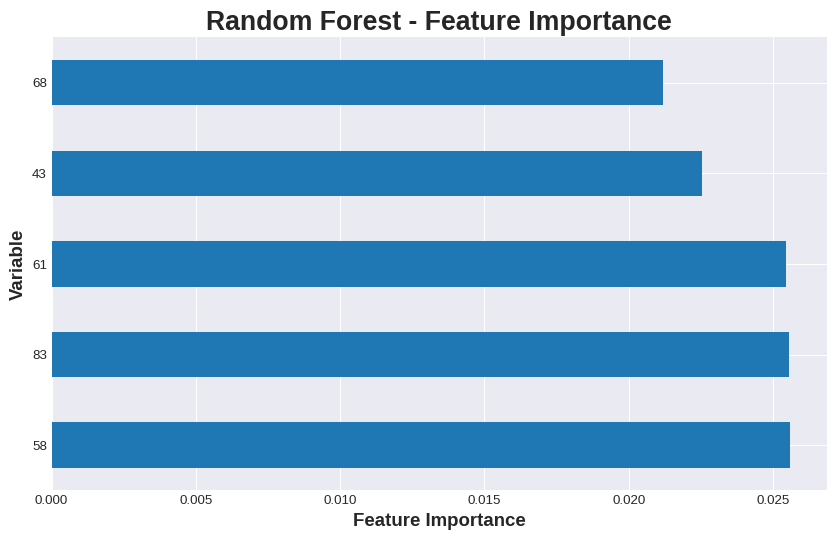

In [192]:
#Setting style for plot
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 600/my_dpi), dpi=my_dpi)

# Feature Importance - Random Forest
# Extracting the relevant model
rf_imp = val_model.named_estimators['rf']

# Fitting the relevant model
rf_imp.fit(X_train_final, y_train)

# Obtaining the score of the relevant model
rf_imp.score(X_val_final, y_val)

# Plotting the Top 5 features of the relevant model
rf_plot = (pd.Series(rf_imp.feature_importances_, index = X_train_final.columns).nlargest(5).plot(kind = 'barh'))

# Labelling Title, y and x axes
plt.title('Random Forest - Feature Importance', fontsize=20, weight='bold')
plt.xlabel("Feature Importance", fontsize=14, weight='bold')
plt.ylabel("Variable", fontsize=14 , weight='bold')

# Renaming X Axis Tick Labels
# rf_plot.set_yticklabels( ('PCA Component 55', 'PCA Component 80', 'PCA Component 58', 'PCA Component 40', 'PCA Component 65') )

#Saving figure
plt.savefig('rf_feat_imp.png')

[22:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


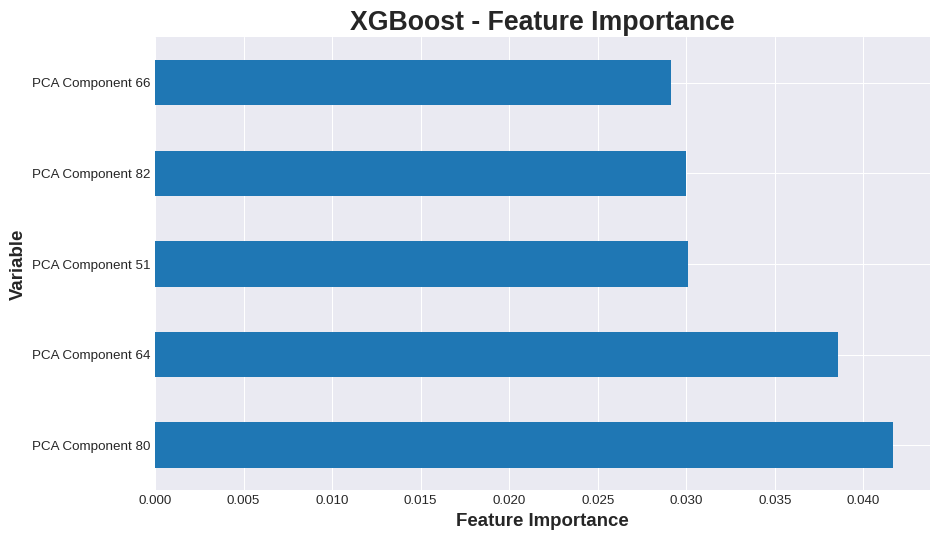

In [ ]:
#Setting style for plot
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 600/my_dpi), dpi=my_dpi)

# Feature Importance - XGBoost
# Extracting the relevant model
xgb_imp = val_model.named_estimators['xgb']

# Fitting the relevant model
xgb_imp.fit(X_train_final, y_train)

# Obtaining the score of the relevant model
xgb_imp.score(X_val_final, y_val)

# Plotting the Top 5 features of the relevant model
xgb_plot = (pd.Series(xgb_imp.feature_importances_, index = X_train_final.columns).nlargest(5).plot(kind = 'barh'))

# Labelling Title, y and x axes
plt.title('XGBoost - Feature Importance', fontsize=20, weight='bold')
plt.xlabel("Feature Importance", fontsize=14, weight='bold')
plt.ylabel("Variable", fontsize=14 , weight='bold')

# Renaming X Axis Tick Labels
xgb_plot.set_yticklabels( ('PCA Component 80', 'PCA Component 64', 'PCA Component 51', 'PCA Component 82', 'PCA Component 66'))

#Saving figure
plt.savefig('xgb_feat_imp.png')

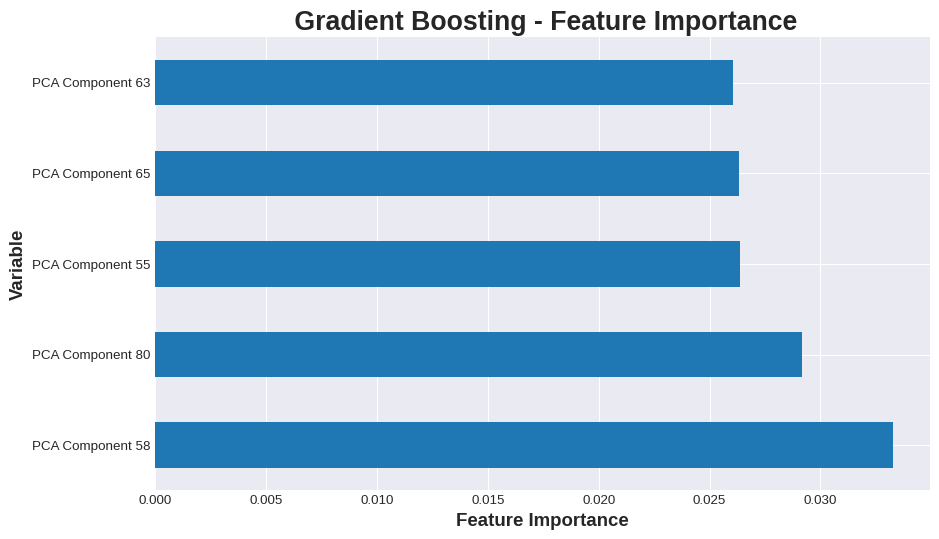

In [ ]:
#Setting style for plot
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 600/my_dpi), dpi=my_dpi)

# Feature Importance - Gradient Boosting
# Extracting the relevant model
gb_imp = val_model.named_estimators['gb']

# Fitting the relevant model
gb_imp.fit(X_train_final, y_train)

# Obtaining the score of the relevant model
gb_imp.score(X_val_final, y_val)

# Plotting the Top 5 features of the relevant model
gb_plot = (pd.Series(gb_imp.feature_importances_, index = X_train_final.columns).nlargest(5).plot(kind = 'barh'))

# Labelling Title, y and x axes
plt.title(' Gradient Boosting - Feature Importance', fontsize=20, weight='bold')
plt.xlabel("Feature Importance", fontsize=14, weight='bold')
plt.ylabel("Variable", fontsize=14 , weight='bold')

# Renaming X Axis Tick Labels
gb_plot.set_yticklabels( ('PCA Component 58', 'PCA Component 80', 'PCA Component 55', 'PCA Component 65', 'PCA Component 63'))

#Saving figure
plt.savefig('gb_feat_imp.png')

In [216]:
# Creating list of PCA Components
pca_components = list(range(1, 86))
pca_components = ['PCA Component ' + str(x) for x in pca_components]

# Extracting Keyword Columns
X_columns = X_train.iloc[:, 5:581].columns

# Creating table of 
pca_weightings_df = pd.DataFrame(pca.components_, columns=X_columns, index=pca_components)
pca_weightings_df.shape


(85, 576)

In [211]:
# Reviewing bottom 5 variables in PCA Component 80
bottom_weightings = pd.DataFrame(pca_weightings_df.loc['PCA Component 80'].sort_values(ascending = True)[:5])
bottom_weightings

,PCA Component 80
parka,-0.21
discount,-0.20
maitland,-0.17
macmillan,-0.17
essentials,-0.17


In [212]:
# Reviewing top 5 variables in PCA Component 80
top_weightings = pd.DataFrame(pca_weightings_df.loc['PCA Component 80'].sort_values(ascending = False)[:5])
top_weightings

,PCA Component 80
tkmaxx,0.26
gold,0.22
jack,0.22
authorised,0.18
priced,0.18


In [208]:
# Finding weightings for top 2 and bottom 2 relevant variables in PCA Component 80
selected_weightings = top_weightings[:2].sum() + bottom_weightings[:2].abs().sum()
selected_weightings

PCA Component 80   0.89
dtype: float64

In [205]:
# Total Weightings for PCA Component 80
total_weightings = pca_weightings_df.loc['PCA Component 80'].abs().sum()
total_weightings

10.122735075856188

In [206]:
# Percentage top two variables make up of PCA Component 80's variance
selected_weightings/total_weightings * 100

PCA Component 80   8.83
dtype: float64